![OpenSARlab notebook banner](NotebookAddons/blackboard-banner.png)

# Exploring SAR Data and SAR Time Series Analysis with Supplied Data

### Franz J Meyer; University of Alaska Fairbanks & Josef Kellndorfer, [Earth Big Data, LLC](http://earthbigdata.com/)

<img src="NotebookAddons/UAFLogo_A_647.png" width="170" align="right" /></font>

This notebook introduces you to the analysis of deep multi-temporal SAR image data stacks in the framework of *Jupyter Notebooks*. The Jupyter Notebook environment is easy to launch in any web browser for interactive data exploration with provided or new training data. Notebooks are comprised of text written in a combination of executable python code and markdown formatting including latex style mathematical equations. Another advantage of Jupyter Notebooks is that they can easily be expanded, changed, and shared with new data sets or newly available time series steps. Therefore, they provide an excellent basis for collaborative and repeatable data analysis.

**This notebook covers the following data analysis concepts:**

- How to load time series stacks into Jupyter Notebooks and how to explore image content using basic functions such as mean value calculation and histogram analysis.
- How to apply calibration constants to covert initial digital number (DN) data into calibrated radar cross section information.
- How to subset images create time series information of calibrated SAR amplitude values.
- How to explore the time-series information in SAR data stacks for environmental analysis.

**Important Notes about JupyterHub**

Your JupyterHub server will automatically shutdown when left idle for more than 1 hour. Your notebooks will not be lost but you will have to restart their kernels and re-run them from the beginning. You will not be able to seamlessly continue running a partially run notebook.

## 0. Importing Relevant Python Packages

In this notebook we will use the following scientific libraries:

- [Pandas](https://pandas.pydata.org/) is a Python library that provides high-level data structures and a vast variety of tools for analysis. The great feature of this package is the ability to translate rather complex operations with data into one or two commands. Pandas contains many built-in methods for filtering and combining data, as well as the time-series functionality.
- [GDAL](https://www.gdal.org/) is a software library for reading and writing raster and vector geospatial data formats. It includes a collection of programs tailored for geospatial data processing. Most modern GIS systems (such as ArcGIS or QGIS) use GDAL in the background.
- [NumPy](http://www.numpy.org/) is one of the principal packages for scientific applications of Python. It is intended for processing large multidimensional arrays and matrices, and an extensive collection of high-level mathematical functions and implemented methods makes it possible to perform various operations with these objects.
- [Matplotlib](https://matplotlib.org/index.html) is a low-level library for creating two-dimensional diagrams and graphs. With its help, you can build diverse charts, from histograms and scatterplots to non-Cartesian coordinates graphs. Moreover, many popular plotting libraries are designed to work in conjunction with matplotlib. </li>

In [1]:
%%capture
from pathlib import Path

import pandas as pd # for DatetimeIndex
from osgeo import gdal # for GetRasterBand, Open, ReadAsArray
gdal.UseExceptions()
import numpy as np #for log10, mean, percentile, power

%matplotlib inline
import matplotlib.pylab as plb # for add_patch, add_subplot, figure, hist, imshow, set_title, xaxis,_label, text 
import matplotlib.pyplot as plt # for add_subplot, axis, figure, imshow, legend, plot, set_axis_off, set_data,
                                # set_title, set_xlabel, set_ylabel, set_ylim, subplots, title, twinx
import matplotlib.patches as patches  # for Rectangle
import matplotlib.animation as an # for FuncAnimation
from matplotlib import rc 

from IPython.display import HTML

---
## 1. Load Data Stack

<img src="NotebookAddons/Nepalclimate.jpeg" width="400" align="right" /> 

This notebook will be using a 70-image deep L-band SAR data stack over Nepal for a first experience with time series processing. The L-band data were acquired by the ALOS PALSAR sensor and are available to us through the services of the [Alaska Satellite Facility](https://www.asf.alaska.edu/). 

Nepal is an interesting site for this analysis due to the significant seasonality of precipitation that is characteristic for this region. Nepal is said to have five seasons: spring, summer, monsoon, autumn and winter. Precipitation is low in the winter (November - March) and peaks dramatically in the summer, with top rain rates in July, August, and September (see figure to the right). As SAR is sensitive to changes in soil moisture, these weather patterns have a noticeable impact on the Radar Cross Section ($\sigma$) time series information. 

We will analyze the variation of $\sigma$ values over time and will interpret them in the context of rainfall rates in the imaged area. 

Before we get started, let's first **create a working directory for this analysis and change into it:**

In [2]:
data_dir = Path.cwd() / "data_time_series_example"
data_dir.mkdir(exist_ok=True)

In [3]:
import asf_search as asf
from getpass import getpass

import asf_search as asf
import pprint

wkt = "POLYGON((-57.759 -3.5099,-56.459 -3.5099,-56.459 -2.6352,-57.759 -2.6352,-57.759 -3.5099))"

opts=asf.ASFSearchOptions(**{
    "maxResults": 250,
    "intersectsWith": wkt,
    "processingLevel": [
        "GCOV"
    ],
    "dataset": [
        "NISAR"
    ],
    "productionConfiguration": [
        "PR"
    ],
    "host": "cmr.uat.earthdata.nasa.gov"
})

session = asf.ASFSession(cmr_host='cmr.uat.earthdata.nasa.gov')
session.auth_with_token(getpass('UAT EDL token'))

response = asf.search(opts=opts)

# to download all hdf5 files from our 250 results, we can use the ASFSearchResults.find_urls() helper method
hdf5_files = response.find_urls(extension='.h5', directAccess=False)
asf.download_urls(hdf5_files, data_dir, session=session, processes=4)

/tmp/ipykernel_706/953403368.py:24: DeprecationWarning: Use of `cmr_host` keyword with `ASFSession` is deprecated for asf-search versions >= 7.0.9, and may be removed in a future major release.
To authenticate an EDL token for a non-prod deployment of CMR, set the `edl_host` keyword instead. 
(ex: session arugments for authenticating against uat: `ASFSession(edl_host="uat.urs.earthdata.nasa.gov")`)
  session = asf.ASFSession(cmr_host='cmr.uat.earthdata.nasa.gov')


KeyboardInterrupt: Interrupted by user

In [ ]:
# TODO delete any uneeded data and copy the valid file 6 times



In [4]:
gcov_files = sorted(list(data_dir.glob("*.h5")))
num_files = len(gcov_files)
gcov_files

[PosixPath('/home/jovyan/opensarlab-notebooks/NISAR/data_time_series_example/NISAR_L2_PR_GCOV_087_039_D_090_2005_DHDH_A_20251102T220639_20251102T220714_T00407_N_F_J_001-Copy1.h5'),
 PosixPath('/home/jovyan/opensarlab-notebooks/NISAR/data_time_series_example/NISAR_L2_PR_GCOV_087_039_D_090_2005_DHDH_A_20251102T220639_20251102T220714_T00407_N_F_J_001-Copy2.h5'),
 PosixPath('/home/jovyan/opensarlab-notebooks/NISAR/data_time_series_example/NISAR_L2_PR_GCOV_087_039_D_090_2005_DHDH_A_20251102T220639_20251102T220714_T00407_N_F_J_001-Copy3.h5'),
 PosixPath('/home/jovyan/opensarlab-notebooks/NISAR/data_time_series_example/NISAR_L2_PR_GCOV_087_039_D_090_2005_DHDH_A_20251102T220639_20251102T220714_T00407_N_F_J_001-Copy4.h5'),
 PosixPath('/home/jovyan/opensarlab-notebooks/NISAR/data_time_series_example/NISAR_L2_PR_GCOV_087_039_D_090_2005_DHDH_A_20251102T220639_20251102T220714_T00407_N_F_J_001-Copy5.h5'),
 PosixPath('/home/jovyan/opensarlab-notebooks/NISAR/data_time_series_example/NISAR_L2_PR_GCOV_0

We will **retrieve the relevant data** from an [Amazon Web Service (AWS)](https://aws.amazon.com/) cloud storage bucket **using the following command:**

In [5]:
# s3_path = 's3://asf-jupyter-data-west/time_series.zip'
# time_series_path = path/Path(s3_path).name

# !aws --region=us-west-2 --no-sign-request s3 cp $s3_path $time_series_path

Now, let's **unzip the file (overwriting previous extractions) and clean up after ourselves:**

In [6]:
# if time_series_path.exists():
#     asfn.asf_unzip(str(path), str(time_series_path))
#     time_series_path.unlink()

The following lines set path variables needed for data processing. This step is not necessary but it saves a lot of extra typing later. **Define variables for the main data directory as well as for the files containing data and image information:**

In [7]:
# datadirectory = path/'time_series/S32644X696260Y3052060sS1-EBD'
# datefile = datadirectory/'S32644X696260Y3052060sS1_D_vv_0092_mtfil.dates'
# imagefile = datadirectory/'S32644X696260Y3052060sS1_D_vv_0092_mtfil.vrt'
# imagefile_cross = datadirectory/'S32644X696260Y3052060sS1_D_vh_0092_mtfil.vrt'

In [8]:
#!ls *.vrt #Uncomment this line to see a List of the files 

In [9]:
# !python -m pip install h5py
# !python -m pip install h5netcdf

In [10]:
# TODO https://stackoverflow.com/questions/61133916/is-there-in-python-a-single-function-that-shows-the-full-structure-of-a-hdf5-fi/61134014#61134014

import h5py

# List all groups and datasets in H5 file
def print_all_objs(name, obj):
    print(obj)

with h5py.File(open(gcov_files[0], "rb")) as f: 

    f.visititems(print_all_objs)

<HDF5 group "/science" (1 members)>
<HDF5 group "/science/LSAR" (2 members)>
<HDF5 group "/science/LSAR/GCOV" (2 members)>
<HDF5 group "/science/LSAR/GCOV/grids" (2 members)>
<HDF5 group "/science/LSAR/GCOV/grids/frequencyA" (13 members)>
<HDF5 dataset "HHHH": shape (15984, 16668), type "<f4">
<HDF5 dataset "HVHV": shape (15984, 16668), type "<f4">
<HDF5 dataset "listOfCovarianceTerms": shape (2,), type "|S4">
<HDF5 dataset "listOfPolarizations": shape (2,), type "|S2">
<HDF5 dataset "mask": shape (15984, 16668), type "|u1">
<HDF5 dataset "numberOfLooks": shape (15984, 16668), type "<f4">
<HDF5 dataset "numberOfSubSwaths": shape (), type "|u1">
<HDF5 dataset "projection": shape (), type "<u4">
<HDF5 dataset "rtcGammaToSigmaFactor": shape (15984, 16668), type "<f4">
<HDF5 dataset "xCoordinateSpacing": shape (), type "<f8">
<HDF5 dataset "xCoordinates": shape (16668,), type "<f8">
<HDF5 dataset "yCoordinateSpacing": shape (), type "<f8">
<HDF5 dataset "yCoordinates": shape (15984,), type

In [11]:
import re
import h5py
import numpy as np
import xarray as xr
import dask.array as da
from dask import delayed

_date_regex = re.compile(r"_(\d{8}T\d{6})_")
def _get_ts(filename):
    match = _date_regex.search(filename)
    if match:
        ts_str = match.group(1)
        return np.datetime64(f"{ts_str[:4]}-{ts_str[4:6]}-{ts_str[6:8]}T{ts_str[9:11]}:{ts_str[11:13]}:{ts_str[13:15]}") 
    return np.datetime64("NaT")

def open_gcov(file_paths, vars_to_load=("HHHH","HVHV","mask","numberOfLooks"), freqs=("A","B"), max_xy_chunk=2048):
    file_paths = sorted(file_paths)
    group = {f: f"/science/LSAR/GCOV/grids/frequency{f}" for f in freqs}
    with h5py.File(file_paths[0], "r") as f0:
        g = f0[group[freqs[0]]]
        x, y = g["xCoordinates"][...], g["yCoordinates"][...]
        proj = g["projection"][()]
    ny, nx = len(y), len(x)
    time = np.array([_get_ts(p.name) for p in file_paths])
    chunks = (1, 1, min(ny, max_xy_chunk), min(nx, max_xy_chunk))  # (time, frequency, y, x)

    data_vars = {}
    for v in vars_to_load:
        per_freq = []
        for freq in freqs:
            with h5py.File(file_paths[0], "r") as f0:
                dt = f0[f"{group[freq]}/{v}"].dtype
            planes = [da.from_delayed(delayed(lambda p, d: h5py.File(p,"r")[d][...])(p, f"{group[freq]}/{v}"),
                                      shape=(ny, nx), dtype=dt)[None, None, ...]
                      for p in file_paths]
            per_freq.append(da.concatenate(planes, axis=0))
        stacked = da.concatenate(per_freq, axis=1).rechunk(chunks)
        data_vars[v] = (("time","frequency","y","x"), stacked)

    return xr.Dataset(
        data_vars=data_vars,
        coords={"time": time, "frequency": np.array(list(freqs)), "y": y, "x": x},
        attrs={"source": "NISAR L2 GCOV", "projection": proj},
    )


ds = open_gcov(gcov_files)
ds

<xarray.Dataset> Size: 48GB
Dimensions:        (time: 7, frequency: 2, y: 15984, x: 16668)
Coordinates:
  * time           (time) datetime64[s] 56B 2025-11-02T22:06:39 ... 2025-11-0...
  * frequency      (frequency) <U1 8B 'A' 'B'
  * y              (y) float64 128kB 9.819e+06 9.819e+06 ... 9.499e+06 9.499e+06
  * x              (x) float64 133kB 3.312e+05 3.312e+05 ... 6.645e+05 6.646e+05
Data variables:
    HHHH           (time, frequency, y, x) float32 15GB dask.array<chunksize=(1, 1, 2048, 2048), meta=np.ndarray>
    HVHV           (time, frequency, y, x) float32 15GB dask.array<chunksize=(1, 1, 2048, 2048), meta=np.ndarray>
    mask           (time, frequency, y, x) uint8 4GB dask.array<chunksize=(1, 1, 2048, 2048), meta=np.ndarray>
    numberOfLooks  (time, frequency, y, x) float32 15GB dask.array<chunksize=(1, 1, 2048, 2048), meta=np.ndarray>
Attributes:
    source:      NISAR L2 GCOV
    projection:  32721

In [12]:
# TODO: remove this when there is real NISAR data

fake_times = pd.date_range(
    start="2025-11-02T22:06:39",
    periods=ds.sizes["time"],
    freq="D"
)

ds = ds.assign_coords(time=fake_times)
ds

<xarray.Dataset> Size: 48GB
Dimensions:        (time: 7, frequency: 2, y: 15984, x: 16668)
Coordinates:
  * frequency      (frequency) <U1 8B 'A' 'B'
  * y              (y) float64 128kB 9.819e+06 9.819e+06 ... 9.499e+06 9.499e+06
  * x              (x) float64 133kB 3.312e+05 3.312e+05 ... 6.645e+05 6.646e+05
  * time           (time) datetime64[ns] 56B 2025-11-02T22:06:39 ... 2025-11-...
Data variables:
    HHHH           (time, frequency, y, x) float32 15GB dask.array<chunksize=(1, 1, 2048, 2048), meta=np.ndarray>
    HVHV           (time, frequency, y, x) float32 15GB dask.array<chunksize=(1, 1, 2048, 2048), meta=np.ndarray>
    mask           (time, frequency, y, x) uint8 4GB dask.array<chunksize=(1, 1, 2048, 2048), meta=np.ndarray>
    numberOfLooks  (time, frequency, y, x) float32 15GB dask.array<chunksize=(1, 1, 2048, 2048), meta=np.ndarray>
Attributes:
    source:      NISAR L2 GCOV
    projection:  32721

---
## 3. Assess Image Acquisition Dates

Before we start analyzing the available image data, we want to examine the content of our data stack. **First, we read the image acquisition dates for all files in the time series and create a *pandas* date index.**

In [13]:
# if datefile.exists():
#     with open(str(datefile), 'r') as f:
#         dates = f.readlines()
#         tindex = pd.DatetimeIndex(dates)

From the date index, we **make and print a lookup table for band numbers and dates:**

In [14]:
# if imagefile.exists():
#     j = 1
#     print('Bands and dates for', imagefile)
#     for i in tindex:
#         print("{:4d} {}".format(j, i.date()),end=' ')
#         j += 1
#         if j%5 == 1: print()

In [15]:
ds.time.values

array(['2025-11-02T22:06:39.000000000', '2025-11-03T22:06:39.000000000',
       '2025-11-04T22:06:39.000000000', '2025-11-05T22:06:39.000000000',
       '2025-11-06T22:06:39.000000000', '2025-11-07T22:06:39.000000000',
       '2025-11-08T22:06:39.000000000'], dtype='datetime64[ns]')

---
## 4. Explore the Available Image Data 

To **open an image file using the gdal.Open() function.** This returns a variable (img) that can be used for further interactions with the file:

In [16]:
# if imagefile.exists():
#     img = gdal.Open(str(imagefile))

To **explore the image (number of bands, pixels, lines),** you can use several functions associated with the image object (img) created in the last code cell:

In [17]:
# print(img.RasterCount) # Number of Bands
# print(img.RasterXSize) # Number of Pixels
# print(img.RasterYSize) # Number of Lines

In [18]:
ds.coords

Coordinates:
  * frequency  (frequency) <U1 8B 'A' 'B'
  * y          (y) float64 128kB 9.819e+06 9.819e+06 ... 9.499e+06 9.499e+06
  * x          (x) float64 133kB 3.312e+05 3.312e+05 ... 6.645e+05 6.646e+05
  * time       (time) datetime64[ns] 56B 2025-11-02T22:06:39 ... 2025-11-08T2...

In [19]:
ds.HHHH.shape

(7, 2, 15984, 16668)

### 4.1 Reading Data from an Image Band

**To access any band in the image**, use GDAL's *GetRasterBand(x)* function. Replace the band_num value with the number of the band you wish to access.

In [20]:
# band_num = 70 
# band = img.GetRasterBand(band_num)

Once a band is seleted, several functions associated with the band are available for further processing, e.g., *band.ReadAsArray(xoff=0,yoff=0,xsize=None,ysize=None)*

**Let's read the entire raster layer for the band:**

In [21]:
# raster = band.ReadAsArray()

### 4.2 Extracting Subsets from a Larger Image Frame

Because of the potentially large data volume when dealing with time series data stacks, it may be prudent to read only a subset of data. 

Using GDAL's *ReadAsArray()* function, subsets can be requested by defining pixel offsets and subset size:

**img.ReadAsArray(xoff=0, yoff=0, xsize=None, ysize=None)**

- *xoff, yoff* are the offsets from the upper left corner in pixel/line coordinates. 
- *xsize, ysize* specify the size of the subset in x-direction (left to right) and y-direction (top to bottom).

For example, we can **read only a subset of 5x5 pixels with an offset of 5 pixels and 20 lines:**

In [22]:
# raster_sub = band.ReadAsArray(5, 20, 50, 50)

In [23]:
# Note that you do not have to supply exact existing coords from your dataset for your slice bounds. 
# If your x coords are [0,3,6,9,12,15,18,21], using a slice(2, 14) will give you [3,6,9,12]

subset_utm = ds.sel(
    x=slice(400000.0, 500000.0),
    y=slice(9700000.0, 9600000.0),
    time=slice("2025-11-02", "2025-11-08"),
    frequency=["A", "B"]
)
subset_utm

<xarray.Dataset> Size: 5GB
Dimensions:        (time: 7, frequency: 2, y: 5000, x: 5000)
Coordinates:
  * frequency      (frequency) <U1 8B 'A' 'B'
  * y              (y) float64 40kB 9.7e+06 9.7e+06 9.7e+06 ... 9.6e+06 9.6e+06
  * x              (x) float64 40kB 4e+05 4e+05 4e+05 ... 5e+05 5e+05 5e+05
  * time           (time) datetime64[ns] 56B 2025-11-02T22:06:39 ... 2025-11-...
Data variables:
    HHHH           (time, frequency, y, x) float32 1GB dask.array<chunksize=(1, 1, 212, 656), meta=np.ndarray>
    HVHV           (time, frequency, y, x) float32 1GB dask.array<chunksize=(1, 1, 212, 656), meta=np.ndarray>
    mask           (time, frequency, y, x) uint8 350MB dask.array<chunksize=(1, 1, 212, 656), meta=np.ndarray>
    numberOfLooks  (time, frequency, y, x) float32 1GB dask.array<chunksize=(1, 1, 212, 656), meta=np.ndarray>
Attributes:
    source:      NISAR L2 GCOV
    projection:  32721

In [24]:
# Provide your subset coords in 4326 (lat/lon), but keep the dataset in UTM.
# This is useful if you are grabbing some coordinates from Google Maps.

import rioxarray

ds = ds.rio.write_crs(f"EPSG:{ds.projection}")
subset_with_lat_lon_coords = ds.rio.clip_box(
    minx=-57.5, miny=-3.6,
    maxx=-56.5, maxy=-2.6, 
    crs="EPSG:4326"
).sel(
    time=slice("2025-11-02", "2025-11-07"),
    frequency=["A", "B"]
)
subset_with_lat_lon_coords

<xarray.Dataset> Size: 5GB
Dimensions:        (frequency: 2, y: 5528, x: 5560, time: 6)
Coordinates:
  * frequency      (frequency) <U1 8B 'A' 'B'
  * y              (y) float64 44kB 9.713e+06 9.713e+06 ... 9.602e+06 9.602e+06
  * x              (x) float64 44kB 4.444e+05 4.444e+05 ... 5.556e+05 5.556e+05
  * time           (time) datetime64[ns] 48B 2025-11-02T22:06:39 ... 2025-11-...
    spatial_ref    int64 8B 0
Data variables:
    HHHH           (time, frequency, y, x) float32 1GB dask.array<chunksize=(1, 1, 843, 484), meta=np.ndarray>
    HVHV           (time, frequency, y, x) float32 1GB dask.array<chunksize=(1, 1, 843, 484), meta=np.ndarray>
    mask           (time, frequency, y, x) uint8 369MB dask.array<chunksize=(1, 1, 843, 484), meta=np.ndarray>
    numberOfLooks  (time, frequency, y, x) float32 1GB dask.array<chunksize=(1, 1, 843, 484), meta=np.ndarray>
Attributes:
    source:      NISAR L2 GCOV
    projection:  32721

The result is a two dimensional numpy array in the datatpye the data were stored in. **We can inspect these data in python by typing the array name on the commandline**:

In [25]:
# raster_sub

### 4.3 Displaying Bands in the Time Series of SAR Data

<font face="Calibri" size="3"> From the lookup table we know that bands 20 and 27 in the Nepal data stack are from mid February and late August. **Let's take look at these images**. </font>

In [ ]:
# raster_1 = img.GetRasterBand(20).ReadAsArray()
# raster_2 = img.GetRasterBand(27).ReadAsArray()

**4.3.1 Write a Plotting Function**

Matplotlib's plotting functions allow for powerful options to display imagery. We are following some standard approaches for setting up figures.
First we are looking at a **raster band** and it's associated **histogram**.

Our function, *show_image()* takes several parameters:
    
- raster = a numpy two dimensional array 
- tindex = a panda index array for dates
- bandnbr = the band number the corresponds to the raster 
- vmin = minimim value to display 
- vmax = maximum value to display
- output_filename = name of output file, if saving the plot

Note: By default, data will be linearly stretched between vmin and vmax.

*We won't use this function in this notebook but it is a useful utility method, which can be copied and pasted for use in other analyses*

In [ ]:
# def show_image_histogram(raster, tindex, band_nbr, vmin=None, vmax=None, output_filename=None):  
    
#     fig = plb.figure(figsize=(16, 8))
#     ax1 = fig.add_subplot(121)
#     ax2 = fig.add_subplot(122)
    
#     # plot image
#     ax1.imshow(raster, cmap='gray', vmin=vmin, vmax=vmax)
#     ax1.set_title('Image Band {} {}'.format(band_nbr, tindex[band_nbr-1].date()))
#     vmin = np.percentile(raster, 2) if vmin==None else vmin
#     vmax = np.percentile(raster, 98) if vmax==None else vmax
#     ax1.xaxis.set_label_text('Linear stretch Min={} Max={}'.format(vmin, vmax))
    
#     #plot histogram
#     h = ax2.hist(raster.flatten(), bins=200, range=(0, 10000))
#     ax2.xaxis.set_label_text('Amplitude (Uncalibrated DN Values)')
#     ax2.set_title('Histogram Band {} {}'.format(band_nbr, tindex[band_nbr-1].date()))
    
#     if output_filename:
#         plt.savefig(f'{output_filename}', dpi=300, transparent='true')

In [110]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

def show_image_histogram_da(
    da: xr.DataArray,
    vmin: float | None = None,
    vmax: float | None = None,
    bins: int = 200,
    hist_range: tuple[float, float] | None = None,
    output_filename: str | None = None,
):

    da = da.squeeze()

    if vmin is None or vmax is None:
        q = da.quantile([0.05, 0.95], skipna=True)
        if vmin is None:
            vmin = float(q.sel(quantile=0.05).values)
        if vmax is None:
            vmax = float(q.sel(quantile=0.95).values)

    if hist_range is None:
        hist_range = (vmin, vmax)

    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)   
    
    polarization = f"Polarization: {da.name}"
    date = da.time.values.astype(str).split("T")[0]
    frequency = f"Frequency: {da.frequency.values.item()}"
    title_parts = [da.source] if "source" in da.attrs else []
    title_parts.extend([polarization, frequency, date])
    title = " | ".join(title_parts)

    da.plot.imshow(ax=ax1, cmap="gray", add_colorbar=False, vmin=vmin, vmax=vmax)
    ax1.set_title(title)

    if "projection" in raster.attrs:
        xlabel = "Longitude" if da.projection == 4326 else "Easting"
        ylabel = "Latitude" if da.projection == 4326 else "Northing"
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(ylabel)

    da.plot.hist(ax=ax2, bins=bins, range=hist_range)
    ax2.set_xlabel("Amplitude")
    ax2.set_title(f"Histogram ({bins} bins)")

    fig.tight_layout()

    if output_filename:
        plt.savefig(output_filename, dpi=300, transparent=True)

    return fig, (ax1, ax2)

**We won't be calling our new function elsewhere in this notebook, so test it now:**

In [102]:
subset = subset_utm
date = "2025-11-02"
freq = "A"
polarization = "HHHH"

raster = subset.sel(time=date, frequency=freq)[polarization]
raster = raster.assign_attrs({**subset.attrs, **raster.attrs}) # attach global Dataset attributes to DataArray
raster

<xarray.DataArray 'HHHH' (time: 1, y: 5000, x: 5000)> Size: 100MB
dask.array<getitem, shape=(1, 5000, 5000), dtype=float32, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
    frequency  <U1 4B 'A'
  * y          (y) float64 40kB 9.7e+06 9.7e+06 9.7e+06 ... 9.6e+06 9.6e+06
  * x          (x) float64 40kB 4e+05 4e+05 4e+05 ... 5e+05 5e+05 5e+05
  * time       (time) datetime64[ns] 8B 2025-11-02T22:06:39
Attributes:
    source:      NISAR L2 GCOV
    projection:  32721

(<Figure size 1600x800 with 2 Axes>,
 (<Axes: title={'center': 'NISAR L2 GCOV | Polarization: HHHH | Frequency: A | 2025-11-02'}, xlabel='Easting', ylabel='Northing'>,
  <Axes: title={'center': 'Histogram (200 bins)'}, xlabel='Amplitude'>))

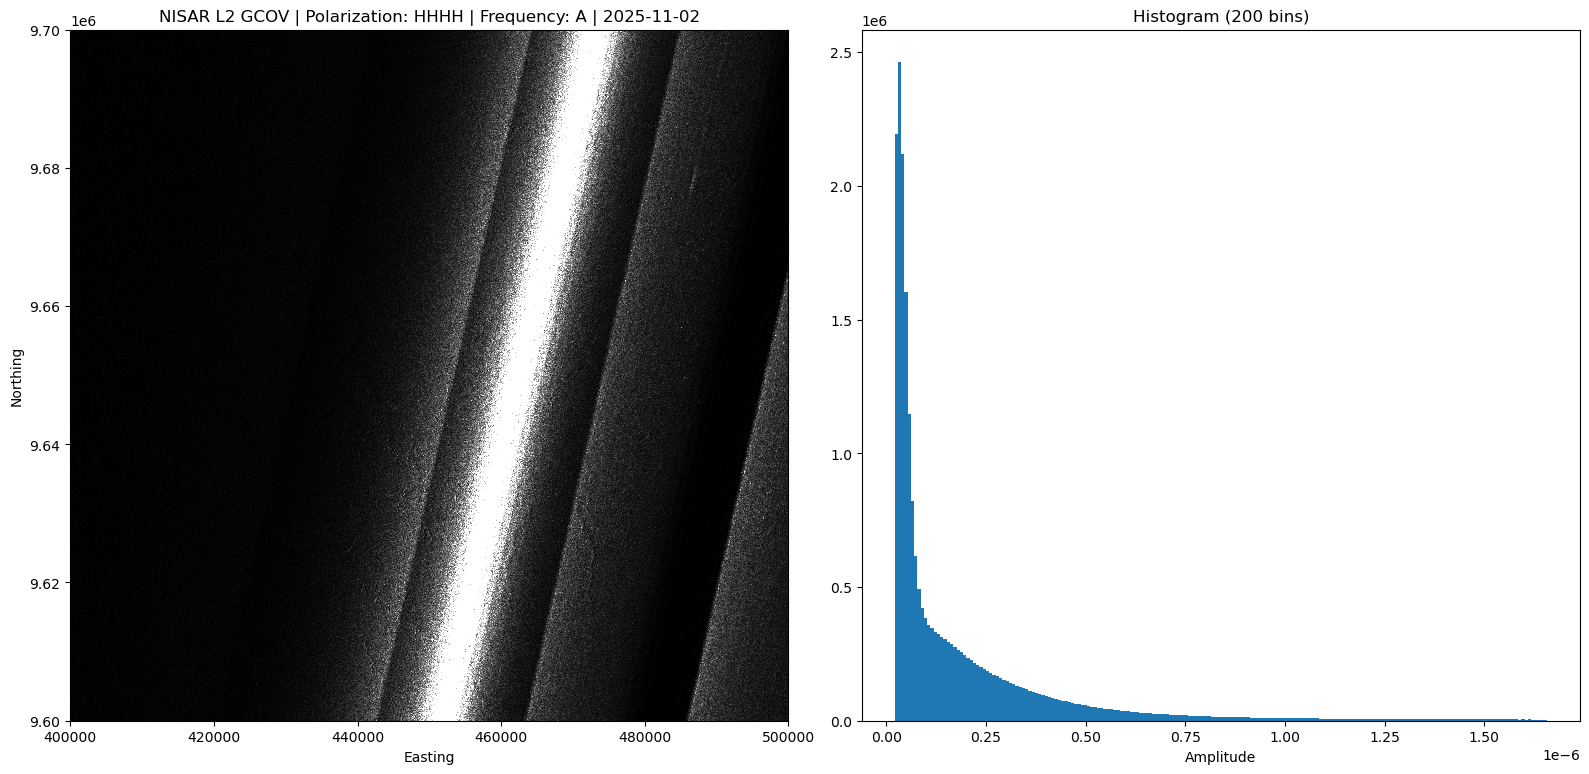

In [111]:
show_image_histogram_da(raster)

In [112]:
plot_dir = Path.cwd() / "time_series_example_plots"
plot_dir.mkdir(exist_ok=True)

(<Figure size 1600x800 with 2 Axes>,
 (<Axes: title={'center': 'NISAR L2 GCOV | Polarization: HHHH | Frequency: A | 2025-11-02'}, xlabel='Easting', ylabel='Northing'>,
  <Axes: title={'center': 'Histogram (200 bins)'}, xlabel='Amplitude'>))

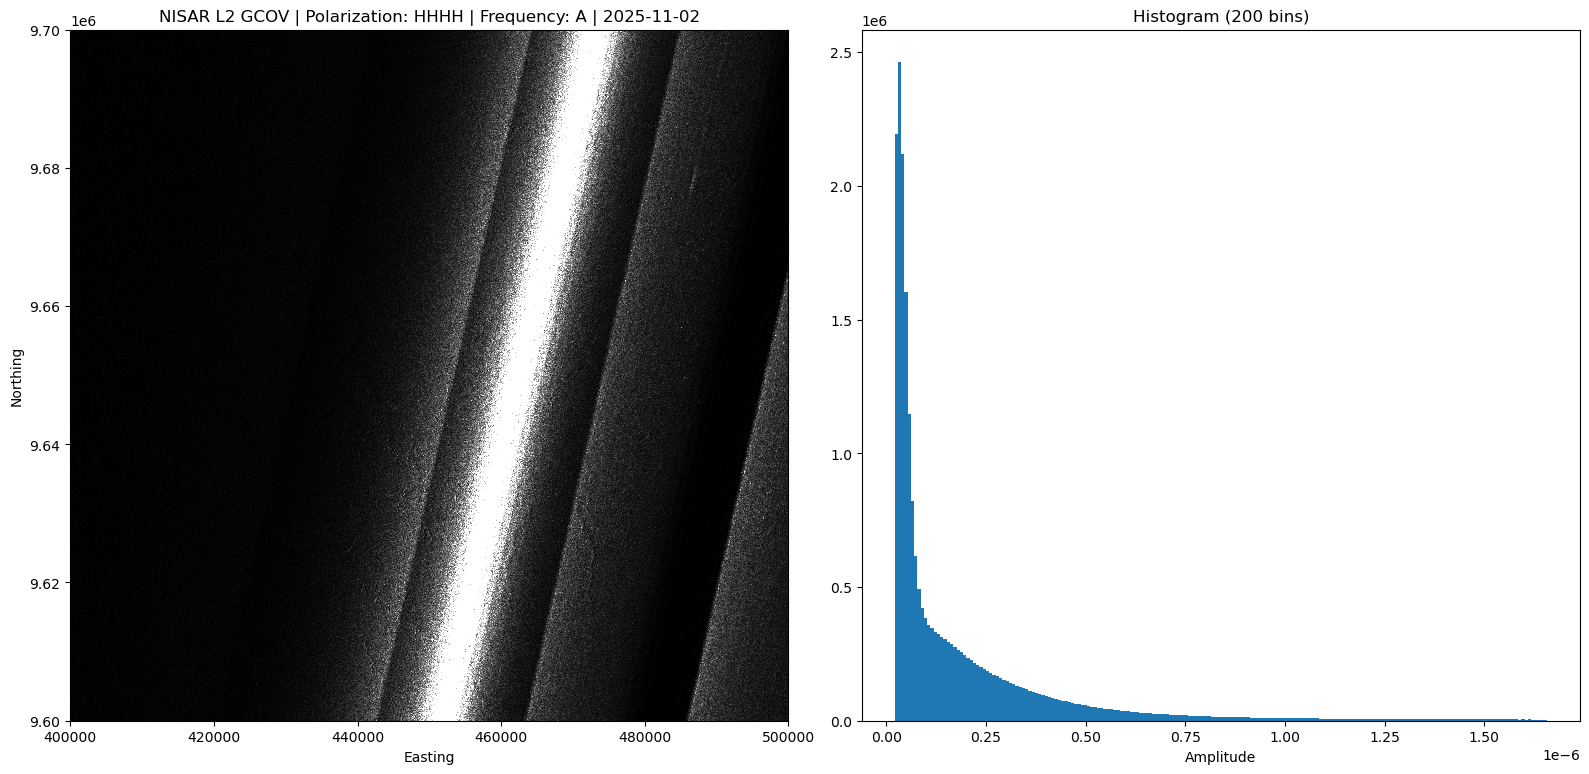

In [114]:
show_image_histogram_da(raster, output_filename=plot_dir / f'image_and_hist_{date}_{polarization}_{freq}.png')

---
## 5. SAR Time Series Visualization, Animation, and Analysis

This section introduces you to the handling and analysis of SAR time series stacks. A focus will be put on time series visualization, which allow us to inspect time series in more depth. Note that html animations are not exported into the pdf file, but will display interactively.

### 5.1 Reading the SAR Time Series Subset

Let's read an image subset (offset 400, 400 /  size 600, 600) of the entire time series data stack. The data are linearly scaled amplitudes represented as unsigned 16 bit integer.

We use the GDAL *ReadAsArray(xoff,yoff,xsize,ysize)* function where *xoff* is the offset in pixels from upper left; *yoff* is the offset in lines from upper left; *xsize* is the number of pixels and *ysize* is the number of lines of the subset.

If *ReadAsArray()* is called without any parameters, the entire image data stack is read. 

Let's first **define a subset and make sure it is in the right geographic location.**

In [ ]:
# Open the image and read the first raster band
band = img.GetRasterBand(1)

# Define the subset
subset = (400, 400, 600, 600)

Now we are ready to **extract this subset from all slices of the data stack.**

In [ ]:
# Plot one band together with the outline of the selected subset to verify its geographic location.
raster = band.ReadAsArray()
vmin = np.percentile(raster.flatten(), 5)
vmax = np.percentile(raster.flatten(), 95)
fig = plb.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(raster, cmap='gray', vmin=vmin, vmax=vmax)
# plot the subset as rectangle
_ = ax.add_patch(patches.Rectangle((subset[0], subset[1]), subset[2], subset[3], fill=False, edgecolor='red'))

In [ ]:
raster0 = band.ReadAsArray(*subset)
bandnbr = 0 # Needed for updates
rasterstack = img.ReadAsArray(*subset)

**Close img, as it is no longer needed in the notebook:**

In [ ]:
img = None

### 5.2 Calibration and Data Conversion between dB and Power Scales

Focused SAR image data natively come in uncalibrated digital numbers (DN) and need to be calibrated to correspond to proper radar cross section information. 

Calibration coefficients for SAR data are often defined in the decibel (dB) scale due to the high dynamic range of the imaging system. For the L-band ALOS PALSAR data at hand, the conversion from uncalibrated DN values to calibrated radar cross section values in dB scale is performed by applying a standard **calibration factor of -83 dB**. 

$\gamma^0_{dB} = 20 \cdot log10(DN) -83$

The data at hand are radiometrically terrain corrected images, which are often expressed as terrain flattened $\gamma^0$ backscattering coefficients. For forest and land cover monitoring applications $\gamma^o$ is the preferred metric.

Let's **apply the calibration constant for our data and export it in *dB* scale:**

In [ ]:
caldB = 20*np.log10(rasterstack) - 83

While **dB**-scaled images are often "visually pleasing", they are often not a good basis for mathematical operations on data. For instance, when we compute the mean of observations, it makes a difference whether we do that in power or dB scale. Since dB scale is a logarithmic scale, we cannot simply average data in that scale. 
    
Please note that the **correct scale** in which operations need to be performed **is the power scale.** This is critical, e.g. when speckle filters are applied, spatial operations like block averaging are performed, or time series are analyzed.

To **convert from dB to power**, apply: $\gamma^o_{pwr} = 10^{\frac{\gamma^o_{dB}}{10}}$

In [ ]:
calPwr = np.power(10., caldB/10.)

### 5.3 Create a Time Series Animation

First, **Create a directory in which to store our plots and move into it:**

In [ ]:
product_path = path/'plots_and_animations'
if not product_path.exists():
    product_path.mkdir()

Now we are ready to **create a time series animation** from the calibrated SAR data.

In [ ]:
%%capture 
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.axis('off')
vmin = np.percentile(caldB.flatten(), 5)
vmax = np.percentile(caldB.flatten(), 95)
r0dB = 20*np.log10(raster0) - 83
im = ax.imshow(r0dB,cmap='gray', vmin=vmin, vmax=vmax)
ax.set_title("{}".format(tindex[0].date()))

def animate(i):
    ax.set_title("{}".format(tindex[i].date()))
    im.set_data(caldB[i])

# Interval is given in milliseconds
ani = an.FuncAnimation(fig, animate, frames=rasterstack.shape[0], interval=400)

**Configure matplotlib's RC settings for the animation:**

In [ ]:
rc('animation', embed_limit=40971520.0)  # We need to increase the limit maybe to show the entire animation

**Create a javascript animation of the time-series running inline in the notebook:**

In [ ]:
HTML(ani.to_jshtml())

**Save the animation (animation.gif):**

In [ ]:
ani.save(f'{product_path}/animation.gif', writer='pillow', fps=2)

### 5.3 Plot the Time Series of Means Calculated Across the Subset

To create the time series of means, we will go through the following steps:
1. Compute means using the data in **power scale** ($\gamma^o_{pwr}$) .
1. Convert the resulting mean values into dB scale for visualization.
1. Plot time series of means.

**Compute the means:**

In [ ]:
rs_means_pwr = np.mean(calPwr,axis=(1, 2))

**Convert the resulting mean value time-series to dB scale for visualization and check that we got the means over time:**

In [ ]:
rs_means_dB = 10.*np.log10(rs_means_pwr)
rs_means_pwr.shape

**Plot and save the time series of means (time_series_means.png):**

In [ ]:
# 3. Now let's plot the time series of means
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(111)
ax1.plot(tindex, rs_means_pwr)
ax1.set_xlabel('Date')
ax1.set_ylabel(r'$\overline{\gamma^o}$ [power]')


ax2 = ax1.twinx()
ax2.plot(tindex, rs_means_dB, color='red')
ax2.set_ylabel(r'$\overline{\gamma^o}$ [dB]')
fig.legend(['power', 'dB'], loc=1)
plt.title(r'Time series profile of average band backscatter $\gamma^o$ ')
plt.savefig(f'{product_path}/time_series_means', dpi=72, transparent='true')

### 5.4 Create Two-Panel Figure with Animated Global Mean $\mu_{\gamma^0_{dB}}$

We use a few Matplotlib functions to **create a side-by-side animation of the dB-scaled imagery and the respective global means $\mu_{\gamma^0_{dB}}$.**

In [ ]:
%%capture 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), gridspec_kw={'width_ratios':[1, 3]})

vmin = np.percentile(rasterstack.flatten(), 5)
vmax = np.percentile(rasterstack.flatten(), 95)
im = ax1.imshow(raster0, cmap='gray', vmin=vmin, vmax=vmax)
ax1.set_title("{}".format(tindex[0].date()))
ax1.set_axis_off()

ax2.axis([tindex[0].date(), tindex[-1].date(), rs_means_dB.min(), rs_means_dB.max()])
ax2.set_ylabel('$\overline{\gamma^o}$ [dB]')
ax2.set_xlabel('Date')
ax2.set_ylim((-10, -5))
l, = ax2.plot([], [])

def animate(i):
    ax1.set_title("{}".format(tindex[i].date()))
    im.set_data(rasterstack[i])
    ax2.set_title("{}".format(tindex[i].date()))
    l.set_data(tindex[:(i+1)], rs_means_dB[:(i+1)])

# Interval is given in milliseconds
ani = an.FuncAnimation(fig, animate, frames=rasterstack.shape[0], interval=400)

**Create a javascript animation of the time-series running inline in the notebook:**

In [ ]:
HTML(ani.to_jshtml())

**Save the animated time-series and histogram (animation_histogram.gif):**

In [ ]:
ani.save(f'{product_path}/animation_histogram.gif', writer='pillow', fps=2)

*Time_Series_Example.ipynb - Version 1.5.3 - February 2024*

*Version Changes*

- *Use raw strings for LateX in matplotlib labels*